In [3]:
import pandas as pd
import numpy as np
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import compose, pipeline, set_config, metrics, svm, preprocessing

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/luca/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/luca/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/luca/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
set_config(display="diagram")

In [4]:
def preprocess_text(text):
    try:
        text = re.sub('[^a-zA-Z]', ' ', text)
        text = text.lower().split()
        text = [word for word in text if not word in set(nltk.corpus.stopwords.words('english'))]
        text = [nltk.stem.WordNetLemmatizer().lemmatize(word) for word in text if len(word) > 1]
        return ' '.join(text)
    except TypeError:
        return ''

def preprocess_series(series):
    texts = []
    for i in range(len(series)):
        texts.append(preprocess_text(series[i]))
    return pd.Series(texts)

In [5]:
diabetes_data = pd.read_csv("8k_diabetes.csv", delimiter=',')

In [8]:
X = diabetes_data[[
    "race",
    "gender",
    "admission_type_id",
    "insulin",
    "diabetesMed",
    "change",
    "payer_code",
    "A1Cresult",
    "metformin",
    "repaglinide",
    "nateglinide",
    "chlorpropamide",
    "glimepiride",
    "glipizide",
    "glyburide",
    "tolbutamide",
    "pioglitazone",
    "rosiglitazone",
    "acarbose",
    "miglitol",
    "tolazamide",
    "glyburide.metformin",
    "glipizide.metformin",
    "num_medications",
    "time_in_hospital",
    "num_lab_procedures",
    "num_procedures",
    "number_outpatient",
    "number_emergency",
    "number_inpatient",
    "number_diagnoses",
    "diag_1_desc",
    "diag_2_desc",
    "diag_3_desc"
]]

In [20]:
for column_name in ["diag_1_desc", "diag_2_desc", "diag_3_desc"]:
    X[column_name] = preprocess_series(X[column_name])

/tmp/ipykernel_94768/3285311414.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column_name] = preprocess_series(X[column_name])


In [18]:
Y = diabetes_data.loc[:,"readmitted"].astype(int)

The goal in this notebook is compare two methods of combining my models. One is to include them both in a single pipeline, while the other is to use a max voting ensemble method to achieve a better result.

In [14]:
column_trans = compose.make_column_transformer(
    (TfidfVectorizer(ngram_range=(1,2)), "diag_1_desc"),
    (TfidfVectorizer(ngram_range=(1,2)), "diag_2_desc"),
    (TfidfVectorizer(ngram_range=(1,2)), "diag_3_desc"),
    (preprocessing.OneHotEncoder(
        sparse=True,
        handle_unknown="ignore"
    ),[
        "race",
        "gender",
        "admission_type_id",
        "insulin",
        "diabetesMed",
        "change",
        "payer_code",
        "A1Cresult",
        "metformin",
        "repaglinide",
        "nateglinide",
        "chlorpropamide",
        "glimepiride",
        "glipizide",
        "glyburide",
        "tolbutamide",
        "pioglitazone",
        "rosiglitazone",
        "acarbose",
        "miglitol",
        "tolazamide",
        "glyburide.metformin",
        "glipizide.metformin",
    ]),
    remainder="passthrough",
)

In [10]:
classifier = svm.SVC()

In [15]:
pipe = pipeline.make_pipeline(column_trans, classifier)

In [22]:
pipe.fit(X,Y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tfidfvectorizer-1',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'diag_1_desc'),
                                                 ('tfidfvectorizer-2',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'diag_2_desc'),
                                                 ('tfidfvectorizer-3',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'diag_3_desc'),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['race', 'gender',
                                                   'admission_type_id',
                                                   'insulin', 'diabetesMed',
                                                   'change', 'payer_code',
                                                   'A1Cresult', 'metformin',
                                                   'repaglinide', 'nateglinide',
                                                   'chlorpropamide',
                                                   'glimepiride', 'glipizide',
                                                   'glyburide', 'tolbutamide',
                                                   'pioglitazone',
                                                   'rosiglitazone', 'acarbose',
                                                   'miglitol', 'tolazamide',
                                                   'glyburide.metformin',
                                                   'glipizide.metformin'])])),
                ('svc', SVC())])

/home/luca/anaconda3/envs/assignment2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


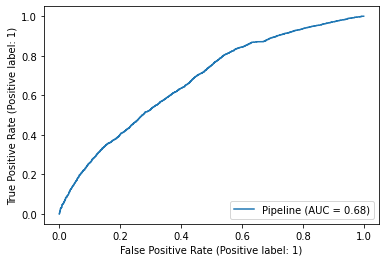

In [23]:
metrics.plot_roc_curve(pipe, X, Y)

Clearly combining my models into a single monolithic model with multiple data types and column transfomers all rolled into one did not improve performance. I will now try using max vote ensemble modeling.

In [6]:
diabetes_data

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted,diag_1_desc,diag_2_desc,diag_3_desc
0,Caucasian,Female,[50-60),?,Elective,Discharged to home,Physician Referral,1,CP,Surgery-Neuro,...,No,No,No,No,No,No,False,Spinal stenosis in cervical region,Spinal stenosis in cervical region,"Effusion of joint, site unspecified"
1,Caucasian,Female,[20-30),[50-75),Urgent,Discharged to home,Physician Referral,2,UN,?,...,No,No,No,No,No,No,False,"First-degree perineal laceration, unspecified ...","Diabetes mellitus of mother, complicating preg...",Sideroblastic anemia
2,Caucasian,Male,[80-90),?,Not Available,Discharged/transferred to home with home healt...,NaN,7,MC,Family/GeneralPractice,...,No,No,No,No,No,Yes,True,Pneumococcal pneumonia [Streptococcus pneumoni...,"Congestive heart failure, unspecified",Hyperosmolality and/or hypernatremia
3,AfricanAmerican,Female,[50-60),?,Emergency,Discharged to home,Transfer from another health care facility,4,UN,?,...,No,No,No,No,No,Yes,False,Cellulitis and abscess of face,Streptococcus infection in conditions classifi...,Diabetes mellitus without mention of complicat...
4,AfricanAmerican,Female,[50-60),?,Emergency,Discharged to home,Emergency Room,5,?,Psychiatry,...,No,No,No,No,Ch,Yes,False,"Bipolar I disorder, single manic episode, unsp...",Diabetes mellitus without mention of complicat...,Depressive type psychosis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,Caucasian,Male,[70-80),?,Elective,Discharged/transferred to SNF,Physician Referral,8,?,Surgery-Cardiovascular/Thoracic,...,No,No,No,No,No,Yes,False,Atherosclerosis of aorta,Cerebral thrombosis without mention of cerebra...,Paroxysmal supraventricular tachycardia
7996,Caucasian,Female,[50-60),?,Urgent,Discharged to home,Emergency Room,2,UN,Emergency/Trauma,...,No,No,No,No,Ch,Yes,False,Disorders of mineral metabolism,Alteration of consciousness,Disorders of mineral metabolism
7997,Caucasian,Male,[50-60),?,Emergency,Discharged/transferred to another short term h...,NaN,1,?,?,...,No,No,No,No,Ch,Yes,False,Coronary atherosclerosis of unspecified type o...,Postmyocardial infarction syndrome,Hyperosmolality and/or hypernatremia
7998,Caucasian,Male,[80-90),?,Urgent,Discharged/transferred to SNF,Emergency Room,7,MC,Surgery-General,...,No,No,No,No,Ch,Yes,False,"Congestive heart failure, unspecified",Paroxysmal supraventricular tachycardia,Endomyocardial fibrosis
